In [1]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import math
import seaborn as sns


from kan_convolutional.KANLinear import KANLinear
from kan_convolutional.KANConv import KAN_Convolutional_Layer
from kan_convolutional import convolution 

# Define the dataset directory
root = "C:\\Users\\Anurag Dutta\\Desktop\\road safety\\data"

In [2]:
class CCTVFootages(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = []
        self.labels = []
        self.class_names = []

        for label, subfolder in enumerate(os.listdir(root_dir)):
            subfolder_path = os.path.join(root_dir, subfolder)
            if os.path.isdir(subfolder_path):
                self.class_names.append(subfolder)  # Store class names
                for img_file in os.listdir(subfolder_path):
                    if img_file.endswith('.jpg'):
                        self.image_files.append(os.path.join(subfolder_path, img_file))
                        self.labels.append(label)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        image = Image.open(img_name).convert('L')
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label

    def get_class_names(self):
        return self.class_names

transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = CCTVFootages(root_dir=root, transform=transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [3]:
# class SimpleCNN(nn.Module):
#     def __init__(self):
#         super(SimpleCNN, self).__init__()
#         self.conv1 = nn.Conv2d(1, 5, kernel_size=3, padding=1)
#         self.conv2 = nn.Conv2d(5, 5, kernel_size=3, padding=1)
#         self.maxpool = nn.MaxPool2d(kernel_size=2)
#         self.flatten = nn.Flatten()
#         self.fc = nn.Linear(5 * 7 * 7, 2)

#     def forward(self, x):
#         x = F.relu(self.conv1(x))
#         x = self.maxpool(x)
#         x = F.relu(self.conv2(x))
#         x = self.maxpool(x)
#         x = self.flatten(x)
#         x = self.fc(x)
#         x = F.log_softmax(x, dim=1)
#         return x

# model = SimpleCNN()

In [4]:
# class SimpleCNN_2(nn.Module):
#     def __init__(self):
#         super(SimpleCNN_2, self).__init__()
#         self.conv1 = nn.Conv2d(1, 5, kernel_size=3, padding=0)
#         self.conv2 = nn.Conv2d(5, 2, kernel_size=3, padding=0)
        
#         self.maxpool = nn.MaxPool2d(kernel_size=2)
        
#         self.fc1 = nn.Linear(2 * 5 * 5, 245)
#         self.fc2 = nn.Linear(245, 2)

#     def forward(self, x):
#         x = torch.relu(self.conv1(x))
#         x = self.maxpool(x)
#         x = torch.relu(self.conv2(x))
#         x = self.maxpool(x)
#         x = x.view(x.size(0), -1)
#         x = torch.relu(self.fc1(x))
#         x = self.fc2(x)
#         x = torch.log_softmax(x, dim=1)

#         return x

# model = SimpleCNN_2()

In [5]:
# class SimpleLinear(nn.Module):
#     def __init__(self):
#         super(SimpleLinear, self).__init__()
#         self.linear = nn.Linear(28*28, 2)
#         self.flatten = nn.Flatten()

#     def forward(self, x):
#         x = self.flatten(x)
#         x = self.linear(x)
#         x = F.log_softmax(x, dim=1)
#         return x

# model = SimpleLinear()

In [6]:
# class ConvNet(nn.Module):
#     def __init__(self):
#         super(ConvNet, self).__init__()
#         self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)
#         self.conv2 = nn.Conv2d(32, 32, kernel_size=5, padding=2)
        
#         self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
#         self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

#         self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
#         self.dropout1 = nn.Dropout(0.25)
#         self.dropout2 = nn.Dropout(0.25)
#         self.dropout3 = nn.Dropout(0.5)

#         self.fc1 = nn.Linear(64 * 7 * 7, 128)
#         self.fc2 = nn.Linear(128, 2)

#     def forward(self, x):
#         x = F.relu(self.conv1(x))
#         x = F.relu(self.conv2(x))
#         x = self.maxpool(x)
#         x = self.dropout1(x)

#         x = F.relu(self.conv3(x))
#         x = F.relu(self.conv4(x))
#         x = self.maxpool(x)
#         x = self.dropout2(x)

#         x = torch.flatten(x, 1) 
#         x = F.relu(self.fc1(x))
#         x = self.dropout3(x)
#         x = self.fc2(x)

#         return x

# model = ConvNet()

In [7]:
# class KANC_MLP(nn.Module):
#     def __init__(self, device: str = 'cpu'):
#         super(KANC_MLP, self).__init__()

#         self.conv1 = KAN_Convolutional_Layer(
#             n_convs = 5,
#             kernel_size=(3, 3),
#             device=device
#         )
#         self.conv2 = KAN_Convolutional_Layer(
#             n_convs = 5,
#             kernel_size=(3, 3),
#             device=device
#         )

#         self.pool = nn.MaxPool2d(kernel_size=(2, 2))
        
#         self.flatten = nn.Flatten()
        
#         self.fc1 = nn.Linear(625, 256)
#         self.fc2 = nn.Linear(256, 2)

#     def forward(self, x):
#         x = self.conv1(x)
#         x = torch.relu(x)
#         x = self.pool(x)
        
#         x = self.conv2(x)
#         x = torch.relu(x)
#         x = self.pool(x)
        
#         x = self.flatten(x)
#         x = torch.relu(self.fc1(x))
#         x = self.fc2(x)
#         x = F.log_softmax(x, dim=1)
        
#         return x

# model = KANC_MLP()

In [8]:
# class KKAN_Convolutional_Network(nn.Module):
#     def __init__(self,device: str = 'cpu'):
#         super().__init__()
#         self.conv1 = KAN_Convolutional_Layer(
#             n_convs = 5,
#             kernel_size= (3,3),
#             device = device
#         )

#         self.conv2 = KAN_Convolutional_Layer(
#             n_convs = 5,
#             kernel_size = (3,3),
#             device = device
#         )

#         self.pool1 = nn.MaxPool2d(
#             kernel_size=(2, 2)
#         )
        
#         self.flat = nn.Flatten() 

#         self.kan1 = KANLinear(
#             625,
#             10,
#             grid_size=10,
#             spline_order=3,
#             scale_noise=0.01,
#             scale_base=1,
#             scale_spline=1,
#             base_activation=nn.SiLU,
#             grid_eps=0.02,
#             grid_range=[0,1],
#         )


#     def forward(self, x):
#         x = self.conv1(x)

#         x = self.pool1(x)

#         x = self.conv2(x)
#         x = self.pool1(x)
#         x = self.flat(x)

#         x = self.kan1(x) 
#         x = F.log_softmax(x, dim=1)

#         return x
    
# model = KKAN_Convolutional_Network()

In [9]:
class NormalConvsKAN(nn.Module):
    def __init__(self):
        super(NormalConvsKAN, self).__init__()
        self.conv1 = nn.Conv2d(1, 5, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(5, 5, kernel_size=3, padding=1)

        self.maxpool = nn.MaxPool2d(kernel_size=2)
        
        self.flatten = nn.Flatten()

        self.kan1 = KANLinear(
            245,
            2,
            grid_size=10,
            spline_order=3,
            scale_noise=0.01,
            scale_base=1,
            scale_spline=1,
            base_activation=nn.SiLU,
            grid_eps=0.02,
            grid_range=[0, 1]
        )

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.kan1(x)
        
        x = F.log_softmax(x, dim=1)  

        return x
    
model = NormalConvsKAN()

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(10): 
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}')

model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.numpy())
        all_labels.extend(labels.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}')

Epoch 1, Loss: 0.6766255910579975
Epoch 2, Loss: 0.6152596427844121
Epoch 3, Loss: 0.5445217444346502
Epoch 4, Loss: 0.4859070571569296
Epoch 5, Loss: 0.428819851233409
Epoch 6, Loss: 0.38765822694851804
Epoch 7, Loss: 0.3655668840958522
Epoch 8, Loss: 0.3289071722672536
Epoch 9, Loss: 0.30136439777337587
Epoch 10, Loss: 0.25839749150551283
Accuracy: 0.9179487179487179, Precision: 0.923690932311622, Recall: 0.9188762626262625, F1 Score: 0.9177735610373181


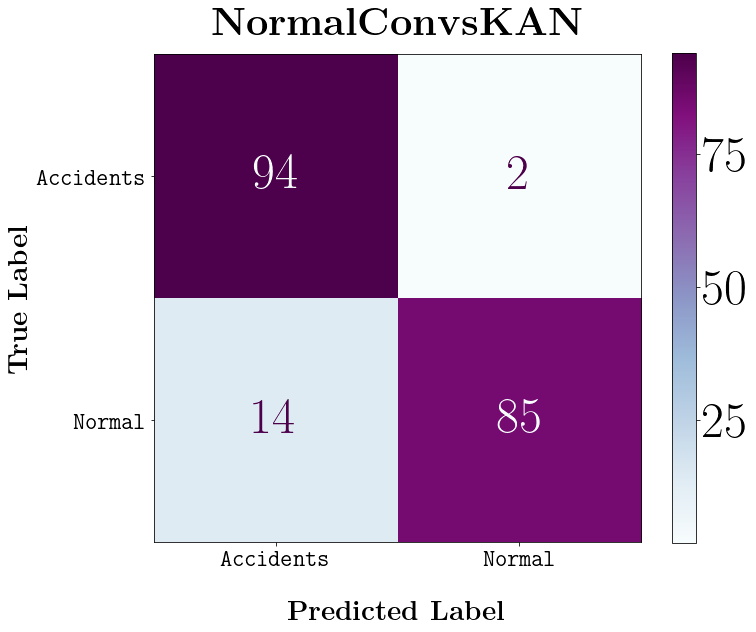

In [12]:
conf_matrix = confusion_matrix(all_labels, all_preds)

formatted_classes = [rf'\texttt{{{cls}}}' for cls in dataset.get_class_names()]

plt.rcParams.update({
    "text.usetex": True,
    "font.size": 50,
    "font.family": "serif",
    "text.latex.preamble": r"\usepackage{amsmath}"
})

fig, ax = plt.subplots(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=formatted_classes)
disp.plot(cmap=plt.cm.BuPu, ax=ax)
plt.title(r'\textbf{NormalConvsKAN}', fontsize=40, pad=20)
plt.xlabel(r'\textbf{Predicted Label}', fontsize=28, labelpad=30)
plt.ylabel(r'\textbf{True Label}', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.tight_layout()

plt.savefig('NormalConvsKAN.pdf', format='pdf')

plt.show()